### Loading the required libraries

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
#dense fully connected layer# dropout is for zero noise layers
import pandas as pd
import numpy as np

from pylab import rcParams

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [0]:
RANDOM_SEED =7124
LABELS = ["Normal", "Fraud"]

In [0]:
!wget https://s3.ap-south-1.amazonaws.com/elasticbeanstalk-ap-south-1-081954957030/Fraud_data_amtstd.csv


Redirecting output to ‘wget-log’.


In [0]:
# Reading the data and lookng at the structure of the data. This data has 30 attributes and 1 lakh records
data = pd.read_csv("Fraud_data_amtstd.csv")
data.shape

(100000, 30)

0    99508
1      492
Name: Class, dtype: int64


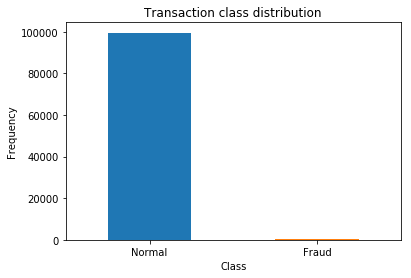

In [0]:
#PLotting the frequencies of fraud and non-fraud transactions in the data
count_classes = pd.value_counts(data['Class'], sort = True)
print(count_classes)

#Drawing a barplot
count_classes.plot(kind = 'bar', rot=0)

#Giving titles and labels to the plot
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [0]:
#Looking at a sample of records
data.head(6)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1.836500,-0.545419,-0.462979,0.537174,-0.426143,-0.100606,-0.584764,-0.103956,2.268429,-0.365185,...,0.085111,0.410736,0.137625,0.602906,-0.350260,0.464407,-0.070917,-0.030486,0.049882,0
1,-4.289880,-2.576061,-0.092256,1.976405,2.810033,-2.669128,-0.981883,-0.470310,-0.025692,0.099528,...,-0.473240,-0.307295,-2.789549,0.578976,-0.837979,0.372843,0.353451,-1.662202,-0.347171,0
2,1.131318,0.139818,0.586921,1.069291,-0.334908,-0.204938,-0.135526,0.043821,-0.121117,0.182139,...,-0.028126,-0.167062,-0.048054,-0.009912,0.417694,-0.479793,0.024360,0.023878,-0.208963,0
3,-0.866956,1.373947,1.948343,2.686750,-0.366790,0.568632,-0.278349,0.739536,-1.655955,0.708396,...,0.022719,-0.070619,-0.080307,0.000816,0.092167,0.159131,0.157940,-0.014370,-0.253595,0
4,-0.842670,1.401843,0.927235,1.070402,0.843883,0.467333,0.366716,0.616739,-1.586963,0.000041,...,0.036573,-0.182581,-0.226834,-1.029794,-0.118762,-0.228960,-0.024250,0.046547,-0.346230,0
5,1.178458,0.166055,-0.101567,0.369453,0.017198,-0.722891,0.396639,-0.187978,-0.483147,0.083094,...,-0.323048,-1.083814,0.049838,-0.002872,0.295810,0.135883,-0.074191,0.004364,-0.150527,0


In [0]:
from sklearn.model_selection import train_test_split

In [0]:
#Converting data to array
data = np.array(data)

In [0]:
#Splitting the data into train and test and observing their dimensions
train, test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)

print(train.shape)
print(test.shape)

(80000, 30)
(20000, 30)


In [0]:
#Obtaining the fraud and non-fraud records in train
print(np.unique(train[:,29], return_counts=True))
print(np.unique(test[:,29], return_counts=True))

(array([0., 1.]), array([79591,   409], dtype=int64))
(array([0., 1.]), array([19917,    83], dtype=int64))


In [0]:
#Now consider only the non-fraud records for training
train_NF = train[train[:,-1] == 0]
X_train_NF = train_NF[:,:-1]

print(X_train_NF.shape)

(79591, 29)


In [0]:
#Separating out the fraud records from the train 
train_F = train[train[:,-1] == 1]
print(train_F.shape)

(409, 30)


In [0]:
#Adding/concatinating the fraud records from train data to the test
test = np.concatenate((test, train_F),axis=0)
print(test.shape)

(20409, 30)


In [0]:
test, eval = train_test_split(test, test_size=0.2, random_state=RANDOM_SEED)

In [0]:
print(test.shape)
print(eval.shape)

(16327, 30)
(4082, 30)


In [0]:
test_NF=test[test[:,29]==0]
print(test_NF.shape)

test_F=test[test[:,29]==1]
print(test_F.shape)

(15942, 30)
(385, 30)


In [0]:
#Separating the independent and the class variable
y_test = test[:,-1]
X_test = test[:,:-1]

In [0]:
print(y_test.shape)
# Expanding the dimensions of y for later concatenation
y_test = np.expand_dims(y_test, axis=1)
print(y_test.shape)

(16327,)
(16327, 1)


#### Model Building

In [0]:
input_dim = X_train_NF.shape[1]
encoding_dim = 15

In [0]:
autoencoder = Sequential()
#20 is masked
autoencoder.add(Dropout(0.2, input_shape=(input_dim,)))
autoencoder.add(Dense(encoding_dim, activation='relu'))
autoencoder.add(Dense(input_dim, activation='linear'))
# input linear so output linear

In [0]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

In [0]:
nb_epoch = 100
batch_size = 32

hist = autoencoder.fit(X_train_NF, X_train_NF,
                       epochs = nb_epoch,
                       batch_size = batch_size,
                       shuffle = True,
                       validation_data=(X_test, X_test),
                       verbose=1).history

Train on 79591 samples, validate on 16327 samples
Epoch 1/100
79591/79591 [==============================] - 6s 74us/step - loss: 0.6020 - mean_squared_error: 0.6020 - val_loss: 0.7508 - val_mean_squared_error: 0.7508
Epoch 2/100
79591/79591 [==============================] - 4s 44us/step - loss: 0.3742 - mean_squared_error: 0.3742 - val_loss: 0.7051 - val_mean_squared_error: 0.7051
Epoch 3/100
79591/79591 [==============================] - 4s 45us/step - loss: 0.3514 - mean_squared_error: 0.3514 - val_loss: 0.6690 - val_mean_squared_error: 0.6690
Epoch 4/100
79591/79591 [==============================] - 4s 45us/step - loss: 0.3492 - mean_squared_error: 0.3492 - val_loss: 0.6901 - val_mean_squared_error: 0.6901
Epoch 5/100
79591/79591 [==============================] - 4s 45us/step - loss: 0.3466 - mean_squared_error: 0.3466 - val_loss: 0.6769 - val_mean_squared_error: 0.6769
Epoch 6/100
79591/79591 [==============================] - 4s 49us/step - loss: 0.3457 - mean_squared_error: 0

79591/79591 [==============================] - 4s 52us/step - loss: 0.3243 - mean_squared_error: 0.3243 - val_loss: 0.6698 - val_mean_squared_error: 0.6698
Epoch 50/100
79591/79591 [==============================] - 4s 52us/step - loss: 0.3286 - mean_squared_error: 0.3286 - val_loss: 0.6546 - val_mean_squared_error: 0.6546
Epoch 51/100
79591/79591 [==============================] - 4s 52us/step - loss: 0.3250 - mean_squared_error: 0.3250 - val_loss: 0.6604 - val_mean_squared_error: 0.6604
Epoch 52/100
79591/79591 [==============================] - 4s 49us/step - loss: 0.3273 - mean_squared_error: 0.3273 - val_loss: 0.6855 - val_mean_squared_error: 0.6855
Epoch 53/100
79591/79591 [==============================] - 4s 53us/step - loss: 0.3230 - mean_squared_error: 0.3230 - val_loss: 0.6862 - val_mean_squared_error: 0.6862
Epoch 54/100
79591/79591 [==============================] - 4s 54us/step - loss: 0.3259 - mean_squared_error: 0.3259 - val_loss: 0.6685 - val_mean_squared_error: 0.6685

79591/79591 [==============================] - 4s 50us/step - loss: 0.3227 - mean_squared_error: 0.3227 - val_loss: 0.6812 - val_mean_squared_error: 0.6812
Epoch 98/100
79591/79591 [==============================] - 4s 53us/step - loss: 0.3205 - mean_squared_error: 0.3205 - val_loss: 0.6853 - val_mean_squared_error: 0.6853
Epoch 99/100
79591/79591 [==============================] - 4s 51us/step - loss: 0.3225 - mean_squared_error: 0.3225 - val_loss: 0.6693 - val_mean_squared_error: 0.6693
Epoch 100/100
79591/79591 [==============================] - 4s 55us/step - loss: 0.3211 - mean_squared_error: 0.3211 - val_loss: 0.6706 - val_mean_squared_error: 0.6706


In [0]:
print(hist)

{'val_loss': [0.7507589702125552, 0.7051287040980526, 0.6690000083653204, 0.6900871010653393, 0.67693355635065, 0.6729460221764841, 0.680518692993976, 0.6903279469547966, 0.6877991638029463, 0.6747852705349244, 0.6833132739927397, 0.6750517156683107, 0.6785481327008053, 0.685097933627828, 0.6885201776621644, 0.6835876798663713, 0.6932391291383273, 0.6727713176669965, 0.67693515047828, 0.6816802999691391, 0.6889021598236613, 0.6994057278577043, 0.6806017168666185, 0.6795722026891977, 0.682717732208536, 0.6800061727195126, 0.6783272336616062, 0.6809327184484062, 0.6852615956878052, 0.6765109566483267, 0.6818752320789185, 0.6716293366099408, 0.6865274958007224, 0.6754862654630426, 0.6704457289852266, 0.680384565685306, 0.6769073770237822, 0.6835362250259709, 0.6691008550726704, 0.6639996219688558, 0.6762694361151167, 0.6661359296011065, 0.6763812208908351, 0.6769485516802098, 0.6669820722126586, 0.6858689682364807, 0.6768942165129795, 0.6688149567311747, 0.669787002011742, 0.6546092805431

In [0]:
##To extract outputs from the hidden layer
from keras import backend as K
layer_output_encoded = K.function([autoencoder.layers[0].input, K.learning_phase()],
                                  [autoencoder.layers[1].output])


In [0]:
encoded = layer_output_encoded([X_train_NF,0])[0]

In [0]:
##To extract outputs from the output layer
layer_output_decoded = K.function([autoencoder.layers[0].input, K.learning_phase()],
                                  [autoencoder.layers[2].output])
decoded = layer_output_decoded([X_train_NF, 0])[0]

In [0]:
## Making predictions on the train data
predictions = autoencoder.predict(X_train_NF)

In [0]:
#Getting the errors from the non fraud data separately 
autoencoder.evaluate(test_NF[:,:29],test_NF[:,:29])

15942/15942 [==============================] - 0s 26us/step


[0.2288174508250488, 0.2288174508250488]

In [0]:
#Getting the errors from the fraud data separately
autoencoder.evaluate(test_F[:,:29], test_F[:,:29])

385/385 [==============================] - 0s 162us/step


[18.96477629426238, 18.96477629426238]

In [0]:
#Obtaining predictions for non fraud records
predictions_nf=autoencoder.predict(test_NF[:,:29])

In [0]:
#Obtaining preictions for fraud records
predictions_f=autoencoder.predict(test_F[:,:29])

In [0]:
#Identifying the error computation method by autoencoder(Mean Squared Error). The computation is as follows 
np.mean(np.square(np.abs(test_NF[:,:29]-predictions_nf)))

0.22881744838731152

In [0]:
#Computing errors on the non-fraud data
errors_nf = np.mean(np.square(np.abs(test_NF[:,:29]-predictions_nf)), axis=1)

In [0]:
#Computing errors on the fraud data
errors_f = np.mean(np.square(np.abs(test_F[:,:29]-predictions_f)), axis=1)

In [0]:
#Computing the distribution of errors in both non-fraud and fraud data
print(np.min(errors_nf))
print(np.max(errors_nf))
print(np.median(errors_nf))

print(np.min(errors_f))
print(np.max(errors_f))
print(np.median(errors_f))

0.01158613765027327
95.28864484394727
0.12178854965091762
0.0449454855433906
124.47924352424931
7.751741972679444


{'boxes': [<matplotlib.lines.Line2D at 0x2998e9bb390>],
 'caps': [<matplotlib.lines.Line2D at 0x2998e9bbda0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2998e9a2a58>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x2998e9a2630>],
 'whiskers': [<matplotlib.lines.Line2D at 0x2998e9bb4e0>,
  <matplotlib.lines.Line2D at 0x2998e9bb978>]}

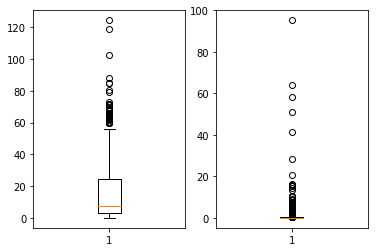

In [0]:
#PLotting the error box plots 
plt.subplot(1, 2, 1)
plt.boxplot(errors_f)

plt.subplot(1, 2, 2)
plt.boxplot(errors_nf)

In [0]:
#Experimentation to fix a threshold for classification of a transaction into fraud or non-fraud
print(sum(errors_nf>np.median(errors_f)))
print(sum(errors_f<np.median(errors_f)))
print(sum(errors_f<np.median(errors_nf)))
sum(errors_nf>np.median(errors_nf))

17
192
6


7971

In [0]:
print(errors_nf.shape)
print(errors_f.shape)

(15942,)
(385,)


In [0]:
print(predictions_nf.shape)
print(predictions_f.shape)

(15942, 29)
(385, 29)


In [0]:
test_pred = autoencoder.predict(X_test[:,:29])
test_recon  = (((test_pred-X_test)**2).mean(-1))

train_pred = autoencoder.predict(X_train_NF[:,:29])
mean_recon = (((train_pred - X_train_NF)**2).mean(-1).mean())

from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix

scores_f1 = []
thres = []

th = 0
for i in range(100):
    th+=0.1
    fraud = (test_recon>mean_recon+th)
    scores_f1.append(f1_score(y_test,fraud))
    thres.append(th+mean_recon)
    

3.02870254362


array([[15883,    59],
       [   80,   305]], dtype=int64)

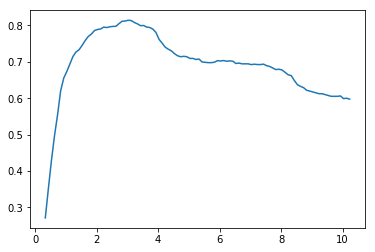

In [0]:
plt.plot(thres, scores_f1)

print(thres[np.array(scores_f1).argmax()])

fraud = (test_recon>thres[np.array(scores_f1).argmax()])

confusion_matrix(y_test, fraud)